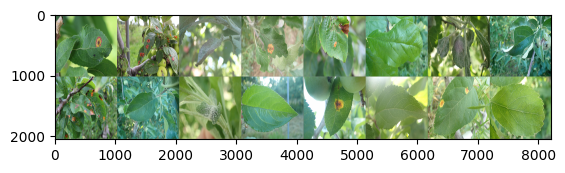

In [1]:
BATCH_SIZE = 16
IMAGE_SIZE = 1024
IS_GREYSCALE = False



import os
import numpy as np
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

base_dir = '/kaggle/input/plant-disease-recognition-dataset'
train_dir = os.path.join(base_dir, 'Train', 'Train')
validation_dir = os.path.join(base_dir, 'Validation', 'Validation')

# Define transformations

if IS_GREYSCALE == True:
    transform = transforms.Compose([
        transforms.Grayscale(),  # Convert to grayscale
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale normalization
    ])
    
    channel = 1
    
else:
    
    transform = transforms.Compose([
        #transforms.Grayscale(),  # Convert to grayscale
        transforms.Resize((IMAGE_SIZE, IMAGE_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485], std=[0.229]),  # Assuming grayscale normalization
    ])
    
    channel = 3

# Create datasets
train_dataset = datasets.ImageFolder(root=train_dir, transform=transform)
validation_dataset = datasets.ImageFolder(root=validation_dir, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
validation_loader = DataLoader(validation_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

def imshow(inp, title=None):
    """Show image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485])
    std = np.array([0.229])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp.squeeze(), cmap='gray')  # Display grayscale image
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

# Get a batch of training data
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Display images
imshow(torchvision.utils.make_grid(images))
plt.show()


In [2]:
images.shape

torch.Size([16, 3, 1024, 1024])

In [3]:
!pip install snntorch --quiet

In [4]:
import snntorch as snn
from snntorch import surrogate
from snntorch import functional as SF
from snntorch import utils

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import itertools
import tqdm

import os
from PIL import Image
from torch.utils.data import Dataset
import random
import math

In [5]:
loss_function = SF.mse_count_loss(correct_rate=0.8, incorrect_rate=0.2)

In [12]:
class Net(torch.nn.Module):
    """Simple spiking neural network in snntorch."""

    def __init__(self, timesteps, hidden, beta, img_size):
        super().__init__()

        self.timesteps = timesteps
        self.hidden = hidden
        self.beta = beta

        
        self.conv1 = nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2)
        self.conv2 = nn.Conv2d(64, 192, kernel_size=5, padding=2)
        self.conv3 = nn.Conv2d(192, 384, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(384, 256, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=3, stride=2)
        
        # layer 1
        self.fc1 = torch.nn.Linear(in_features=12544, out_features=self.hidden)
        self.rlif1 = snn.RLeaky(beta=self.beta, linear_features=self.hidden)

        # layer 2
        self.fc2 = torch.nn.Linear(in_features=self.hidden, out_features=3)
        self.rlif2 = snn.RLeaky(beta=self.beta, linear_features=3)

    def forward(self, x):
        """Forward pass for several time steps."""

        # Initalize membrane potential
        spk1, mem1 = self.rlif1.init_rleaky()
        spk2, mem2 = self.rlif2.init_rleaky()

        # Empty lists to record outputs
        spk_recording = []
        
        
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = self.pool(F.relu(self.conv4(x)))
        x = self.pool(F.relu(self.conv5(x)))
        x = torch.flatten(x, 1)
        


        for step in range(self.timesteps):
            spk1, mem1 = self.rlif1(self.fc1(x), spk1, mem1)
            spk2, mem2 = self.rlif2(self.fc2(spk1), spk2, mem2)
            spk_recording.append(spk2)

        return torch.stack(spk_recording)

In [13]:
hidden = 400
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model = Net(timesteps=20, hidden=hidden, beta=0.8, img_size=IMAGE_SIZE).to(device)

print(device)

cuda


In [ ]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
from sklearn.metrics import f1_score

# Assuming `Net` and `loss_function` are defined elsewhere

num_epochs = 65
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-6)
loss_hist = []
validation_accuracy_hist = []
validation_loss_hist = []


for epoch in range(num_epochs):
    model.train()
    minibatch_counter = 0
    epoch_loss = []

    # Training loop
    for feature, label in tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}', leave=False):
        feature = feature.to(device)
        label = label.to(device)

        spk = model(feature) # forward-pass
        loss_val = loss_function(spk, label) # apply loss
        optimizer.zero_grad() # zero out gradients
        loss_val.backward() # calculate gradients
        optimizer.step() # update weights

        loss_hist.append(loss_val.item())
        epoch_loss.append(loss_val.item())
        minibatch_counter += 1

    avg_epoch_loss = sum(epoch_loss) / minibatch_counter

    # Compute validation accuracy and other metrics
    val_loss = []
    model.eval()
    with torch.no_grad():
        
        total = 0
        acc = 0
        for feature, label in validation_loader:
            feature = feature.to(device)
            label = label.to(device)

            spk = model(feature) # forward-pass
            loss = loss_function(spk, label)
            
            val_loss.append(loss)
            acc += SF.accuracy_rate(spk, label) * spk.size(1)
            total += spk.size(1)
            
    validation_loss = sum(val_loss)/len(val_loss)
    
    validation_loss_hist.append(validation_loss)


    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_epoch_loss:.4f}, Validation Loss: {validation_loss:.4f}, Validation Accuracy: {acc:.2f}%")


Epoch [1/100], Train Loss: 4.8000, Validation Loss: 4.8000, Validation Accuracy: 20.00%


Epoch [2/100], Train Loss: 4.3126, Validation Loss: 2.8606, Validation Accuracy: 20.00%


Epoch [3/100], Train Loss: 2.8893, Validation Loss: 2.6914, Validation Accuracy: 26.00%


Epoch [4/100], Train Loss: 2.7449, Validation Loss: 2.3363, Validation Accuracy: 29.00%


Epoch [5/100], Train Loss: 1.9058, Validation Loss: 1.6435, Validation Accuracy: 23.00%


Epoch [6/100], Train Loss: 1.4996, Validation Loss: 1.5259, Validation Accuracy: 31.00%


Epoch [7/100], Train Loss: 1.4295, Validation Loss: 1.5080, Validation Accuracy: 31.00%


Epoch [8/100], Train Loss: 1.3735, Validation Loss: 1.4503, Validation Accuracy: 35.00%


Epoch [9/100], Train Loss: 1.3330, Validation Loss: 1.4070, Validation Accuracy: 32.00%


Epoch [10/100], Train Loss: 1.2854, Validation Loss: 1.3888, Validation Accuracy: 34.00%


Epoch [11/100], Train Loss: 1.2311, Validation Loss: 1.3011, Validation Accuracy: 38.00%


Epoch [12/100], Train Loss: 1.1844, Validation Loss: 1.2276, Validation Accuracy: 41.00%


Epoch [13/100], Train Loss: 1.1317, Validation Loss: 1.2834, Validation Accuracy: 36.00%


Epoch [14/100], Train Loss: 1.0823, Validation Loss: 1.1570, Validation Accuracy: 38.00%


Epoch [15/100], Train Loss: 1.0283, Validation Loss: 1.1108, Validation Accuracy: 44.00%


Epoch [16/100], Train Loss: 0.9801, Validation Loss: 1.0788, Validation Accuracy: 44.00%


Epoch [17/100], Train Loss: 0.9462, Validation Loss: 1.0010, Validation Accuracy: 49.00%


Epoch [18/100], Train Loss: 0.9165, Validation Loss: 0.9971, Validation Accuracy: 43.00%


Epoch [19/100], Train Loss: 0.8872, Validation Loss: 0.9087, Validation Accuracy: 49.00%


Epoch [20/100], Train Loss: 0.8549, Validation Loss: 0.9011, Validation Accuracy: 48.00%


Epoch [21/100], Train Loss: 0.8180, Validation Loss: 0.8622, Validation Accuracy: 48.00%


Epoch [22/100], Train Loss: 0.7976, Validation Loss: 0.8607, Validation Accuracy: 48.00%


Epoch [23/100], Train Loss: 0.7825, Validation Loss: 0.8174, Validation Accuracy: 49.00%


Epoch [24/100], Train Loss: 0.7622, Validation Loss: 0.8648, Validation Accuracy: 47.00%


Epoch [25/100], Train Loss: 0.7429, Validation Loss: 0.7777, Validation Accuracy: 51.00%


Epoch [26/100], Train Loss: 0.7339, Validation Loss: 0.8144, Validation Accuracy: 51.00%


Epoch [27/100], Train Loss: 0.7132, Validation Loss: 0.7937, Validation Accuracy: 48.00%


Epoch [28/100], Train Loss: 0.6987, Validation Loss: 0.7592, Validation Accuracy: 50.00%


Epoch [29/100], Train Loss: 0.6850, Validation Loss: 0.7339, Validation Accuracy: 51.00%


Epoch [30/100], Train Loss: 0.6624, Validation Loss: 0.8413, Validation Accuracy: 50.00%


Epoch [31/100], Train Loss: 0.6642, Validation Loss: 0.7770, Validation Accuracy: 51.00%


Epoch [32/100], Train Loss: 0.6421, Validation Loss: 0.7288, Validation Accuracy: 52.00%


Epoch [33/100], Train Loss: 0.6284, Validation Loss: 0.6920, Validation Accuracy: 54.00%


Epoch [34/100], Train Loss: 0.6142, Validation Loss: 0.7169, Validation Accuracy: 52.00%


Epoch [35/100], Train Loss: 0.6068, Validation Loss: 0.7256, Validation Accuracy: 52.00%


Epoch [36/100], Train Loss: 0.6011, Validation Loss: 0.6974, Validation Accuracy: 52.00%


Epoch [37/100], Train Loss: 0.5805, Validation Loss: 0.7295, Validation Accuracy: 51.00%


Epoch [38/100], Train Loss: 0.5799, Validation Loss: 0.7229, Validation Accuracy: 53.00%


Epoch [39/100], Train Loss: 0.5640, Validation Loss: 0.6510, Validation Accuracy: 54.00%


Epoch [40/100], Train Loss: 0.5607, Validation Loss: 0.6511, Validation Accuracy: 55.00%


Epoch [41/100], Train Loss: 0.5411, Validation Loss: 0.6596, Validation Accuracy: 53.00%


Epoch [42/100], Train Loss: 0.5405, Validation Loss: 0.6965, Validation Accuracy: 52.00%


Epoch [43/100], Train Loss: 0.5330, Validation Loss: 0.7277, Validation Accuracy: 50.00%


Epoch [44/100], Train Loss: 0.5175, Validation Loss: 0.6685, Validation Accuracy: 52.00%


Epoch [45/100], Train Loss: 0.5063, Validation Loss: 0.6146, Validation Accuracy: 54.00%


Epoch [46/100], Train Loss: 0.5055, Validation Loss: 0.6367, Validation Accuracy: 54.00%


Epoch [47/100], Train Loss: 0.4925, Validation Loss: 0.6345, Validation Accuracy: 54.00%


Epoch [48/100], Train Loss: 0.4935, Validation Loss: 0.5656, Validation Accuracy: 52.00%


Epoch [49/100], Train Loss: 0.4839, Validation Loss: 0.5537, Validation Accuracy: 53.00%


Epoch [50/100], Train Loss: 0.4815, Validation Loss: 0.6301, Validation Accuracy: 54.00%


Epoch [51/100], Train Loss: 0.4691, Validation Loss: 0.5747, Validation Accuracy: 54.00%


Epoch [52/100], Train Loss: 0.4622, Validation Loss: 0.6739, Validation Accuracy: 50.00%


Epoch [53/100], Train Loss: 0.4583, Validation Loss: 0.5986, Validation Accuracy: 55.00%


Epoch [54/100], Train Loss: 0.4493, Validation Loss: 0.5813, Validation Accuracy: 54.00%


Epoch [55/100], Train Loss: 0.4429, Validation Loss: 0.5744, Validation Accuracy: 55.00%


Epoch [56/100], Train Loss: 0.4438, Validation Loss: 0.6380, Validation Accuracy: 53.00%


Epoch [57/100], Train Loss: 0.4351, Validation Loss: 0.6013, Validation Accuracy: 54.00%


Epoch [58/100], Train Loss: 0.4267, Validation Loss: 0.5352, Validation Accuracy: 53.00%


Epoch [59/100], Train Loss: 0.4180, Validation Loss: 0.6091, Validation Accuracy: 53.00%


Epoch [60/100], Train Loss: 0.4102, Validation Loss: 0.5912, Validation Accuracy: 54.00%


Epoch [61/100], Train Loss: 0.4039, Validation Loss: 0.5738, Validation Accuracy: 55.00%


Epoch [62/100], Train Loss: 0.3975, Validation Loss: 0.5674, Validation Accuracy: 54.00%


Epoch [63/100], Train Loss: 0.3921, Validation Loss: 0.5543, Validation Accuracy: 55.00%


Epoch [64/100], Train Loss: 0.3853, Validation Loss: 0.5881, Validation Accuracy: 55.00%


Epoch [65/100], Train Loss: 0.3797, Validation Loss: 0.5482, Validation Accuracy: 56.00%
